In [1]:
import pickle
from scipy.stats.mstats import gmean
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats.mstats import gmean
import xgboost as xgb
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fpath = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files"

In [2]:
df1 = pd.read_stata(fpath + "/full_data_6yr.dta")
df1 = df1[df1.valid == 0]
df1.loc[:,'first_gen_0'] = df1.phe_1 + df1.phe_2 + df1.phe_3
df1.loc[:,'first_gen_1'] = df1.phe_4 + df1.phe_5 + df1.phe_6 + df1.phe_7
for v in ['term_cred_att_', 'enrolled_']:
    df1.loc[:,v+"sum"] = 0
    for t1 in ['sp','su','fa']:
        for t2 in range(1,7):
            t = t1+str(t2)
            df1.loc[:,v+"sum"] = df1.loc[:,v+"sum"] + df1.loc[:,v+t]
df1.loc[:,'avg_cred_att'] = df1.term_cred_att_sum / df1.enrolled_sum
df1.loc[:,'pct_enrolled'] = df1.enrolled_sum / 18

In [3]:
df2 = pd.read_stata(fpath + "/full_data_truncated.dta")
df2 = df2[df2.valid == 1]
df2.loc[:,'first_gen_0'] = df2.phe_1 + df2.phe_2 + df2.phe_3
df2.loc[:,'first_gen_1'] = df2.phe_4 + df2.phe_5 + df2.phe_6 + df2.phe_7
for v in ['term_cred_att_', 'enrolled_', 'available_']:
    df2.loc[:,v+"sum"] = 0
    for t1 in ['sp','su','fa']:
        for t2 in range(1,7):
            t = t1+str(t2)
            df2.loc[:,v+"sum"] = df2.loc[:,v+"sum"] + df2.loc[:,v+t]
df2.loc[:,'avg_cred_att'] = df2.term_cred_att_sum / df2.enrolled_sum
df2.loc[:,'pct_enrolled'] = df2.enrolled_sum / df2.available_sum

In [4]:
df = pd.concat([df1,df2], join='inner')

##### **Note: This model variant only includes 14 predictors, which are all simple non-term-specific predictors

In [5]:
predictors = ['male', 'afam', 'white', 'hisp', 'other', 'first_gen_0', 'first_gen_1', 'cum_gpa', 'pct_enrolled', 'avg_cred_att', 'prop_comp', 'pell_0_ind', 'pell_1_ind']
print(len(predictors))
impute_list_3 = set(["cum_gpa", "prop_comp"])

13


In [6]:
train_df = df[df.valid == 0]
test_df = df[df.valid == 1]
print(train_df.shape,test_df.shape)

(300144, 329) (33115, 329)


In [7]:
def impute(train, test):
    for p in impute_list_3:
        avg_p = np.nanmean(train[p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    return train, test     

In [8]:
train_df_new, test_df_new = impute(train_df, test_df)
X_train = train_df_new.loc[:,predictors]
y_train = train_df_new.grad_6years
X_test = test_df_new.loc[:,predictors]
y_test = test_df_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [10]:
np.random.seed(4321)
val_indices = np.random.choice(train_df.shape[0], int(np.floor(train_df.shape[0]*0.15)), replace=False)
train_val = train_df.iloc[val_indices,:]
train_train = train_df.iloc[np.setdiff1d(np.arange(train_df.shape[0]), val_indices),:]
train_train_new, train_val_new = impute(train_train, train_val)
X_train_train = train_train_new.loc[:,predictors]
y_train_train = train_train_new.grad_6years
X_train_val = train_val_new.loc[:,predictors]
y_train_val = train_val_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
dtrain_train = xgb.DMatrix(X_train_train, y_train_train)
dtrain_val = xgb.DMatrix(X_train_val, y_train_val)

In [12]:
results_dir = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\truncated_simple_predictors_2\\no_truncation\\"

#### (1) Grid Search for max_depth and eta (learning rate)

In [13]:
grid_1 = [(md,e) for md in range(4,8) for e in [0.01, 0.02, 0.05, 0.1, 0.2]]
validation_auc_1 = Counter()
for md,e in grid_1:
    print("max_depth = {0}, eta = {1}:".format(md,e))
    params = {'max_depth': md, 'eta': e, 'min_child_weight': 1, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_1[(md,e)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 4, eta = 0.01:
[0]	validation-auc:0.838963
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.85669
[100]	validation-auc:0.859617
[150]	validation-auc:0.861582
[200]	validation-auc:0.863102
[250]	validation-auc:0.864313
[300]	validation-auc:0.865424
[350]	validation-auc:0.866462
[400]	validation-auc:0.867331
[450]	validation-auc:0.868076
[500]	validation-auc:0.868642
[550]	validation-auc:0.869071
[600]	validation-auc:0.869403
[650]	validation-auc:0.869689
[700]	validation-auc:0.869956
[750]	validation-auc:0.870178
[800]	validation-auc:0.870373
[850]	validation-auc:0.870558
[900]	validation-auc:0.870713
[950]	validation-auc:0.870888
[1000]	validation-auc:0.871023
[1050]	validation-auc:0.87117
[1100]	validation-auc:0.871289
[1150]	validation-auc:0.871398
[1200]	validation-auc:0.8715
[1250]	validation-auc:0.871579
[1300]	validation-auc:0.871682
[1350]	validation-auc:0.871756
[1400]	validation-auc:0.871846
[1450]	validation-auc:0.871904
[1500]	v

[150]	validation-auc:0.87253
[200]	validation-auc:0.872826
[250]	validation-auc:0.873081
[300]	validation-auc:0.873221
[350]	validation-auc:0.873365
Stopping. Best iteration:
[376]	validation-auc:0.873423


max_depth = 6, eta = 0.1:
[0]	validation-auc:0.854912
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.871833
[100]	validation-auc:0.872795
[150]	validation-auc:0.873191
Stopping. Best iteration:
[157]	validation-auc:0.87323


max_depth = 6, eta = 0.2:
[0]	validation-auc:0.854912
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.872317
Stopping. Best iteration:
[85]	validation-auc:0.872624


max_depth = 7, eta = 0.01:
[0]	validation-auc:0.859433
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.867418
[100]	validation-auc:0.868145
[150]	validation-auc:0.869155
[200]	validation-auc:0.869896
[250]	validation-auc:0.870506
[300]	validation-auc:0.871095
[350]	validation-auc:0.871615
[40

In [14]:
for t in validation_auc_1.most_common():
    print(t)

((6, 0.05), 0.873423)
((6, 0.02), 0.873342)
((6, 0.01), 0.87329)
((7, 0.01), 0.873281)
((7, 0.02), 0.873245)
((6, 0.1), 0.87323)
((7, 0.1), 0.873168)
((7, 0.05), 0.873109)
((5, 0.05), 0.873088)
((7, 0.2), 0.873084)
((5, 0.01), 0.873082)
((4, 0.05), 0.872932)
((5, 0.1), 0.872918)
((5, 0.02), 0.87291)
((4, 0.01), 0.872805)
((4, 0.02), 0.872751)
((4, 0.1), 0.872726)
((6, 0.2), 0.872624)
((5, 0.2), 0.872495)
((4, 0.2), 0.872238)


#### (2) Grid Search for min_child_weight (along with max_depth)

In [15]:
md1 = 6
grid_2 = [(md1+i,mcw) for i in [-1,0,1] for mcw in [3,5]]
validation_auc_2 = Counter()
for md,mcw in grid_2:
    print("max_depth = {0}, min_child_weight = {1}:".format(md,mcw))
    params = {'max_depth': md, 'eta': 0.05, 'min_child_weight': mcw, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_2[(md,mcw)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 5, min_child_weight = 3:
[0]	validation-auc:0.848008
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.867519
[100]	validation-auc:0.870473
[150]	validation-auc:0.871732
[200]	validation-auc:0.872251
[250]	validation-auc:0.872634
[300]	validation-auc:0.872912
[350]	validation-auc:0.873051
Stopping. Best iteration:
[376]	validation-auc:0.873115


max_depth = 5, min_child_weight = 5:
[0]	validation-auc:0.848008
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.867521
[100]	validation-auc:0.870473
[150]	validation-auc:0.871718
[200]	validation-auc:0.872265
[250]	validation-auc:0.872599
[300]	validation-auc:0.872881
[350]	validation-auc:0.873061
Stopping. Best iteration:
[354]	validation-auc:0.873084


max_depth = 6, min_child_weight = 3:
[0]	validation-auc:0.854919
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.869308
[100]	validation-auc:0.871585
[150]	validation-auc:0.872

In [16]:
for t in validation_auc_2.most_common():
    print(t)

((7, 5), 0.873294)
((6, 5), 0.873216)
((6, 3), 0.873215)
((5, 3), 0.873115)
((7, 3), 0.873096)
((5, 5), 0.873084)


#### (3) Grid Search for colsample_by_tree

In [17]:
grid_3 = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
validation_auc_3 = Counter()
for cbt in grid_3:
    print("colsample_by_tree = {}:".format(cbt))
    params = {'max_depth': 7, 'eta': 0.05, 'min_child_weight': 5, 'colsample_bytree': cbt, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_3[cbt] = np.max(evals_result['validation']['auc'])
    print("")

colsample_by_tree = 0.5:
[0]	validation-auc:0.849506
Will train until validation-auc hasn't improved in 10 rounds.
Stopping. Best iteration:
[3]	validation-auc:0.862087


colsample_by_tree = 0.55:
[0]	validation-auc:0.849647
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.869539
[100]	validation-auc:0.871734
[150]	validation-auc:0.872811
Stopping. Best iteration:
[174]	validation-auc:0.872993


colsample_by_tree = 0.6:
[0]	validation-auc:0.849647
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.869539
[100]	validation-auc:0.871734
[150]	validation-auc:0.872811
Stopping. Best iteration:
[174]	validation-auc:0.872993


colsample_by_tree = 0.65:
[0]	validation-auc:0.849647
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.870221
[100]	validation-auc:0.872069
[150]	validation-auc:0.872928
[200]	validation-auc:0.873203
[250]	validation-auc:0.873358
Stopping. Best iteration:
[262]	validat

In [19]:
validation_auc_3.most_common()

[(0.7, 0.850754),
 (0.65, 0.850754),
 (0.85, 0.850697),
 (0.8, 0.850697),
 (0.9, 0.850653),
 (0.75, 0.850555),
 (0.6, 0.840852),
 (0.5, 0.83465),
 (0.55, 0.83465)]

#### (4) Finally select the opitmal num_boost_round

In [18]:
params = {'max_depth': 7, 'eta': 0.05, 'min_child_weight': 5, 'colsample_bytree': 0.7, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
evals_result = {}
xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                      early_stopping_rounds = 10,
                      evals_result = evals_result,
                      verbose_eval = 50)
optimal_num_boost_round = np.argmax(evals_result['validation']['auc'])
print("")
print(optimal_num_boost_round)

[0]	validation-auc:0.849647
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.870647
[100]	validation-auc:0.87227
[150]	validation-auc:0.873006
[200]	validation-auc:0.873199
Stopping. Best iteration:
[212]	validation-auc:0.87324


212


#### (5) Train the final xgb model and make predictions for observations in the test set

In [19]:
optimal_num_boost_round = 212

In [20]:
# specify parameters via map
params = {'max_depth': 7, 'eta': 0.05, 'min_child_weight': 5, 'colsample_bytree': 0.7, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
final_xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = optimal_num_boost_round)
# make prediction for observations in the test set
y_test_pred = final_xgb_model.predict(dtest)

In [21]:
print("XGBoost:")
print("AUC = {}".format(round(roc_auc_score(dtest.get_label(), y_test_pred), 4)))

XGBoost:
AUC = 0.8162


In [22]:
# save the model object and predicted scores on the validation sample to local disk
# pickle.dump(final_xgb_model, open(results_dir + "/xgb.p", "wb"))
pickle.dump(list(y_test_pred), open(results_dir + "/y_test_pred_xgb.p", "wb"))

In [23]:
feature_importance = pd.DataFrame(list(final_xgb_model.get_fscore().items()), columns=['feature','importance']).sort_values('importance', ascending=False)
feature_importance.loc[:, 'importance'] = feature_importance.loc[:, 'importance'] / sum(feature_importance.loc[:, 'importance'])
yy = feature_importance.loc[:, 'importance'].iloc[:20]
xx = feature_importance.loc[:, 'feature'].iloc[:20]

In [24]:
xgb_summary = feature_importance.rename(columns = {'feature':'predictor_name',
                                                   'importance':'feature_importance'})\
.loc[:,['predictor_name', 'feature_importance']]
xgb_summary = xgb_summary.merge(pd.DataFrame({'predictor_name': predictors}), on=['predictor_name'], how='right')\
.sort_values(['feature_importance', 'predictor_name'], ascending=[False, True]).fillna(0)
xgb_summary.to_csv(results_dir + "xgb_summary.csv", index=False)

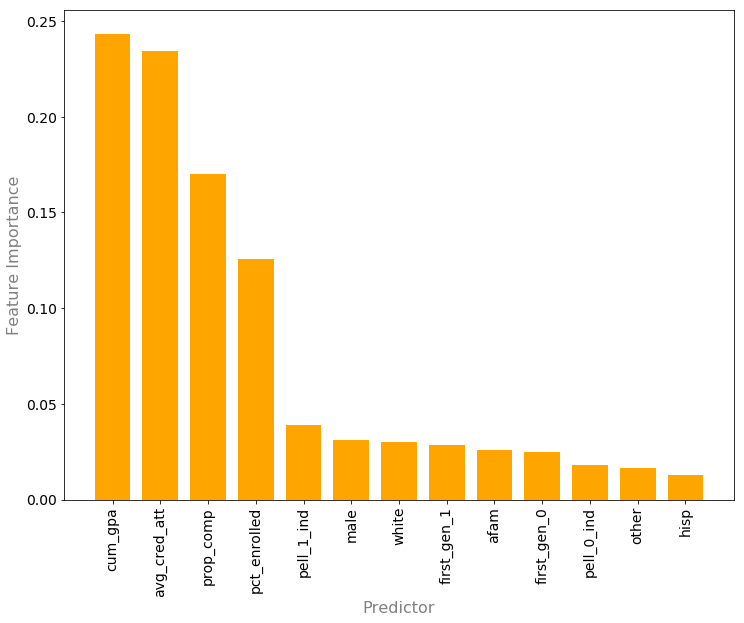

In [26]:
fig = plt.figure(figsize=(12,9))
plt.bar(list(range(13)), yy, width=0.75, color = "orange")
plt.xticks(list(range(13)), xx, rotation = 'vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Predictor", fontsize=16, color="gray")
plt.ylabel("Feature Importance", fontsize=16, color="gray")
plt.savefig(results_dir + "XGBoost_variable_importance.png")
plt.show()

In [27]:
def find_optimal_threshold(p,r,t):
    to_drop = np.union1d(np.where(pd.isnull(p[:-1]) == True)[0], np.where(pd.isnull(r[:-1]) == True)[0])
    to_drop = np.union1d(to_drop, np.where(pd.isnull(t) == True)[0])
    to_keep = np.setdiff1d(np.array(list(range(len(p)-1))), to_drop)
    p,r,t = p[to_keep],r[to_keep],t[to_keep]
    f1 = 2*p*r/(p+r)
    best_t = t[np.argmax(f1)]
    best_t
    return best_t

def cross_validation(train, xgb_params, nbr):
    threshold_list = []
    auc_list = []
    k_fold =  StratifiedKFold(n_splits = 10, random_state = 12345, shuffle=True)
    for train_indices, test_indices in k_fold.split(train, train.grad_6years):
        train_part = train.iloc[train_indices,:]
        test_part = train.iloc[test_indices,:]
        train_part_new, test_part_new = impute(train_part, test_part)
        X_1 = train_part_new.loc[:,predictors]
        y_1 = train_part_new.grad_6years
        X_2 = test_part_new.loc[:,predictors]
        y_2 = test_part_new.grad_6years
        dtrain_cv = xgb.DMatrix(X_1,y_1)
        dtest_cv = xgb.DMatrix(X_2,y_2)
        xgb_cv_model = xgb.train(params=xgb_params, dtrain=dtrain_cv, num_boost_round = nbr)
        y_2_pred = xgb_cv_model.predict(dtest_cv)
        p,r,t = precision_recall_curve(y_2, y_2_pred)
        auc = roc_auc_score(y_2, y_2_pred)
        threshold_list.append(find_optimal_threshold(p,r,t))
        auc_list.append(auc)
    print(np.mean(auc_list), np.std(auc_list, ddof=1))
    return gmean(threshold_list)

In [28]:
final_params = {'max_depth': 7, 'eta': 0.05, 'min_child_weight': 5, 'colsample_bytree': 0.7, 
                'subsample': 0.8, 
                'objective': 'binary:logistic', 'eval_metric': ['auc'],
                'seed': 12345}
best_threshold = cross_validation(train_df, final_params, optimal_num_boost_round)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

0.8731628054800705 0.0013896373265129506


In [30]:
best_threshold

0.3622659

In [32]:
def create_confusion_matrix(y_test_pred, threshold, fname):
    cm_arr = confusion_matrix(y_test, np.where(y_test_pred > threshold, 1, 0))
    cm_df = pd.DataFrame(cm_arr, columns=['Pred_0','Pred_1'], index=['Real_0', 'Real_1'])
    cm_df.loc[:,''] = cm_df.sum(axis=1)
    cm_df.loc['',:] = cm_df.sum(axis=0)
    print(cm_df)
    print("")
    p1 = cm_df.iloc[1,1]/cm_df.iloc[2,1]
    r1 = cm_df.iloc[1,1]/cm_df.iloc[1,2]
    p0 = cm_df.iloc[0,0]/cm_df.iloc[2,0]
    r0 = cm_df.iloc[0,0]/cm_df.iloc[0,2]    
    print("F1 score = {}".format(round(2*p1*r1/(p1+r1),4)))    
    cm_df.to_csv(results_dir + fname + ".csv")
    return p1,r1,p0,r0,round(2*p1*r1/(p1+r1),4)

In [33]:
print("F1 threshold = {}:\n".format(str(round(best_threshold,3))))
pr_xgb = create_confusion_matrix(y_test_pred, best_threshold, "XGBoost_cm1")

F1 threshold = 0.362:

         Pred_0   Pred_1         
Real_0  11718.0  10090.0  21808.0
Real_1   1159.0  10148.0  11307.0
        12877.0  20238.0  33115.0

F1 score = 0.6434


In [34]:
num_of_0 = int(round((1-np.mean(train_df.grad_6years))*len(y_test)))
y_test_pred_binary = np.ones(len(y_test))
y_test_pred_binary[np.argsort(y_test_pred)[:num_of_0]] = 0
alternative_threshold = y_test_pred[np.argsort(y_test_pred)[num_of_0]]
print("Alternative threshold = {}:\n".format(str(round(alternative_threshold,3))))
pr2_xgb = create_confusion_matrix(y_test_pred_binary, best_threshold, "XGBoost_cm2")

Alternative threshold = 0.78:

         Pred_0   Pred_1         
Real_0  17762.0   4046.0  21808.0
Real_1   3881.0   7426.0  11307.0
        21643.0  11472.0  33115.0

F1 score = 0.652


In [35]:
precision_recall_df = pd.DataFrame([(best_threshold,)+pr_xgb,(alternative_threshold,)+pr2_xgb]).round(4)
precision_recall_df.index = ['F1','Same_Graduation_Rate']
precision_recall_df.columns = ['threshold','precision_1','recall_1','precision_0','recall_0','f1_score']
precision_recall_df.to_csv(results_dir + "XGBoost_precision_recall.csv", index=True)

#### Reorganize files of key evaluation metrics for the four non-truncated models: OLS, Logit, RF, XGBoost

In [10]:
# Extract all of the key evaluation metrics of the four non-truncated models that only include simple non-term-specific predictors,
# which will be used to populate column (2) within the Appendix Table A1 and Figure 1 of the paper
cstat = [0.8467,0.8441,0.8780,0.8885]
m_dict = {'Logit': 'LR1', 'OLS': 'OLS',
          'RF': 'RF', 'XGBoost': 'XGBoost'}
m_list = ['Logit', 'OLS', 'RF', 'XGBoost']
summary = []
for c,m in zip(cstat,m_list):
    summary.append((m,c)+tuple(pd.read_csv(results_dir + "\\{}_precision_recall.csv".format(m_dict[m])).iloc[0,1:]))
summary_df = pd.DataFrame(summary, columns=['model','c-statistic','threshold','precision_1','recall_1',
                                            'precision_0','recall_0','f1_score_1'])
summary_df.loc[:,'f1_score_0'] = 2*summary_df.precision_0*summary_df.recall_0/(summary_df.precision_0+summary_df.recall_0)
summary_df.to_csv(results_dir + "cleaned_results\\main_eval_metrics.csv", index=False)